In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'

In [4]:
def model(z, sigma = .1):
    z = z * np.pi
    x = np.sin(z)**2
    return x

In [5]:
def noisemodel(x, z, sigma = 0.1):
    x = x + np.random.randn(*x.shape) * sigma
    return x

In [6]:
z0 = np.ones(20) * 0.25
zdim = len(z0)
x0 = model(z0)
print(x0, zdim)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5] 20


In [7]:
cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)

Creating new cache.


In [8]:
MAX_EPOCHS = 100
EXPECTED_N = 20000

In [9]:
intensity = None

for _ in range(1):
    if intensity is None:
        intensity = swyft.get_unit_intensity(expected_n=EXPECTED_N, dim=zdim)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    cache.grow(intensity)
    cache.simulate(model)
    points = swyft.Points(cache, intensity, noisemodel)
    re = swyft.RatioEstimator(points, device=DEVICE)
    re.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

Simulate:   1%|          | 107/20183 [00:00<00:18, 1061.71it/s]

Adding 20183 new samples. Run simulator!


Simulate: 100%|██████████| 20183/20183 [00:15<00:00, 1321.64it/s]


yshape (shape of features between head and legs): 20
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 2117.705722808838
Validation loss: 2069.052137374878
Validation loss: 2032.7033100128174
Validation loss: 2016.1814308166504
Validation loss: 2009.9130821228027
Validation loss: 2005.2978229522705
Validation loss: 2011.0702953338623
Total epochs: 7
LR iteration 1
Validation loss: 1980.3572025299072
Validation loss: 1983.1368045806885
Total epochs: 2
LR iteration 2
Validation loss: 1959.1403007507324
Validation loss: 1961.1528778076172
Total epochs: 2


In [10]:
z, p = re.posterior(x0, [19])

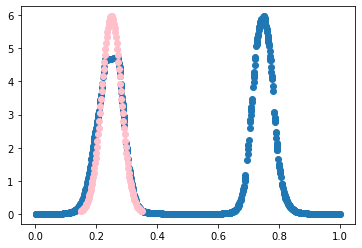

In [11]:
plt.scatter(z,p);
plt.scatter(np.linspace(0.15,0.35,100),
            np.max(p)*np.exp(-0.5*(model(0.25)-model(np.linspace(0.15,0.35,100)))**2/0.1**2),c='pink');

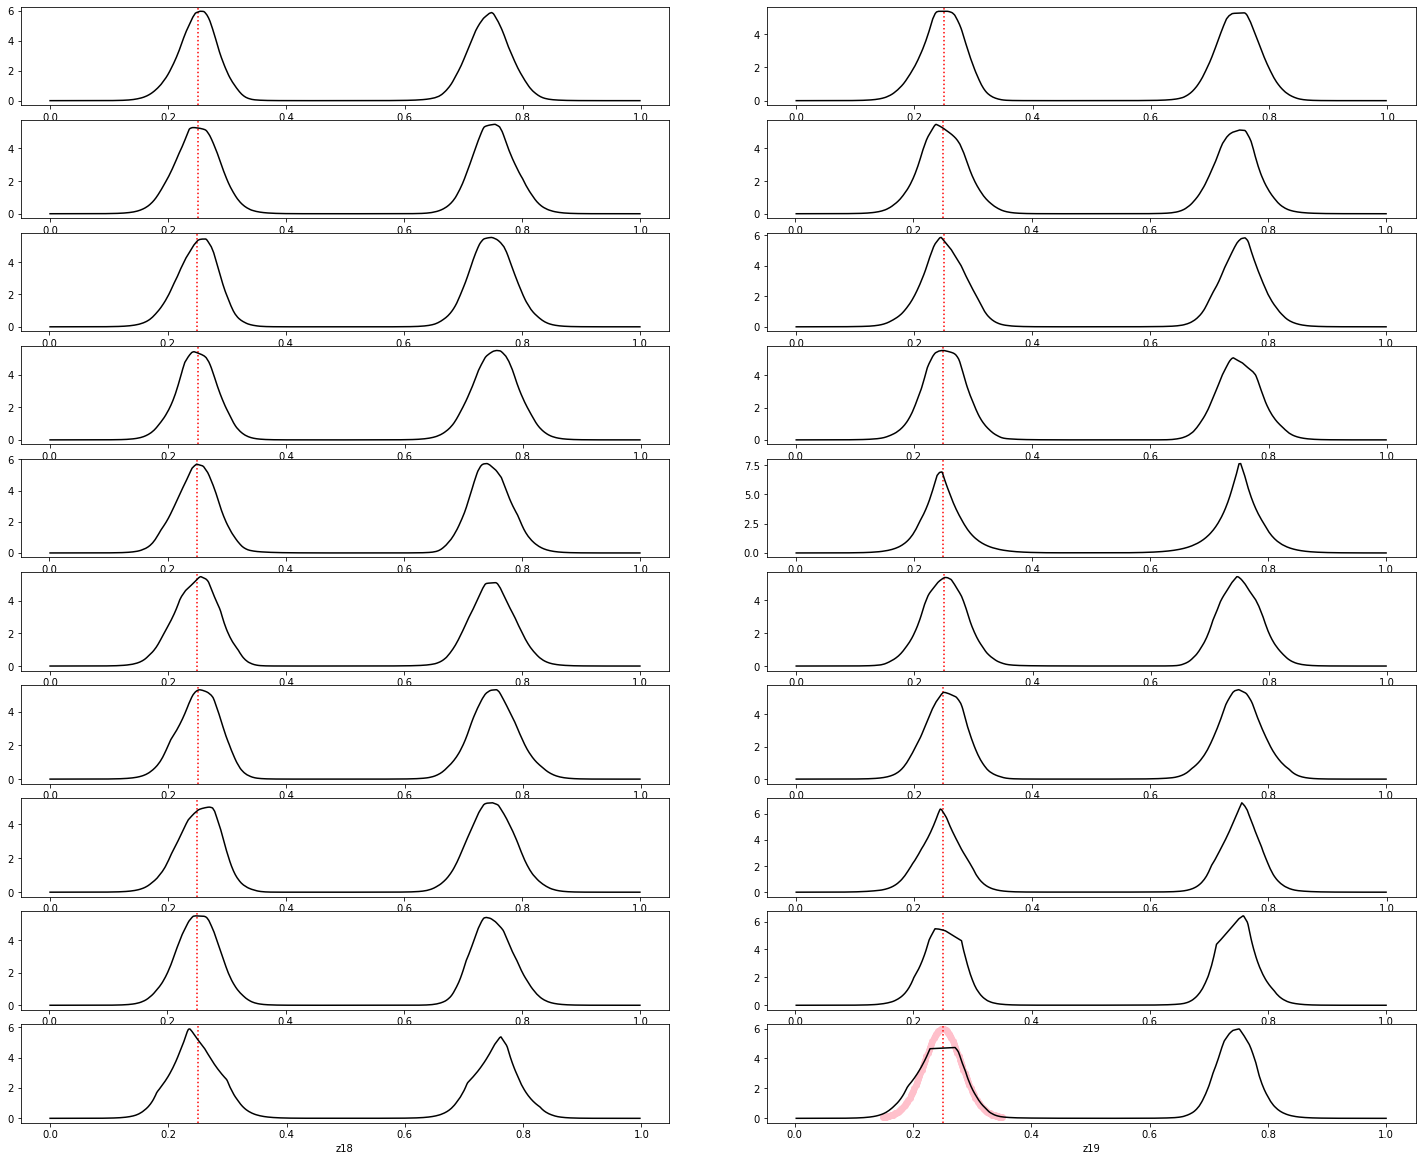

In [12]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (25, 20),ncol=2)
plt.scatter(np.linspace(0.15,0.35,100),
            np.max(p)*np.exp(-0.5*(model(0.25)-model(np.linspace(0.15,0.35,100)))**2/0.1**2),c='pink');

In [13]:
re2 = swyft.RatioEstimator(points, combinations = [[0, 1]], device=DEVICE)
re2.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4,0.5e-4])

yshape (shape of features between head and legs): 20
Start training
LR iteration 0
Validation loss: 88.28709876537323
Validation loss: 69.65628290176392
Validation loss: 67.23988497257233
Validation loss: 63.04459422826767
Validation loss: 64.6623649597168
Total epochs: 5
LR iteration 1
Validation loss: 61.515787452459335
Validation loss: 57.90321770310402
Validation loss: 58.730070039629936
Total epochs: 3
LR iteration 2
Validation loss: 60.21737000346184
Validation loss: 58.936421290040016
Validation loss: 56.91707506775856
Validation loss: 57.97155502438545
Total epochs: 4
LR iteration 3
Validation loss: 57.78832885622978
Validation loss: 55.68724262714386
Validation loss: 55.31003564596176
Validation loss: 56.55196103453636
Total epochs: 4


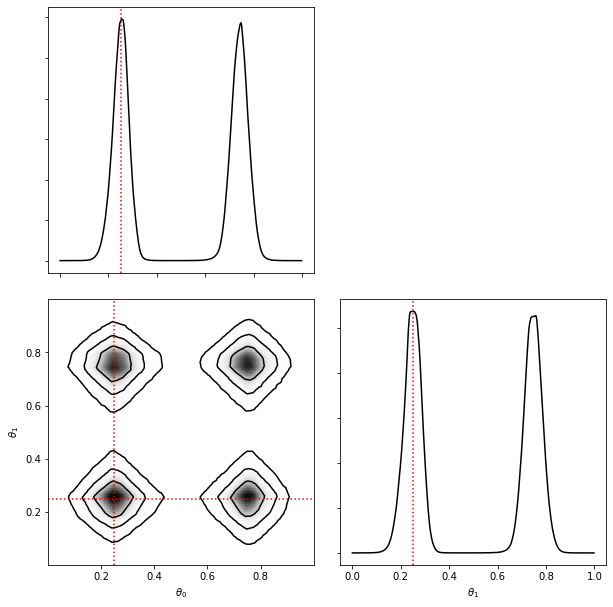

In [15]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 10, params=[0,1],
       labels=['$\\theta_0$','$\\theta_1$'],max_n_points=10000);